In [111]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!pip install catboost

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.simplefilter('ignore')

import shap
import time

In [71]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
original = pd.read_csv("credit_risk_dataset.csv")

In [72]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [73]:
original.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [74]:
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [76]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [77]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [78]:
#handling missing values by replacing with median value calculated
#original['person_emp_length'].median() to calculate the median when the data is sorted frm that column
original['person_emp_length'] = original['person_emp_length'].fillna(original['person_emp_length'].median())
original['loan_int_rate'] = original['loan_int_rate'].fillna(original['loan_int_rate'].median())

In [79]:
train = pd.concat([train, original], ignore_index = True)
train['id'] = np.arange(len(train)) ##....


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          91226 non-null  int32  
 1   person_age                  91226 non-null  int64  
 2   person_income               91226 non-null  int64  
 3   person_home_ownership       91226 non-null  object 
 4   person_emp_length           91226 non-null  float64
 5   loan_intent                 91226 non-null  object 
 6   loan_grade                  91226 non-null  object 
 7   loan_amnt                   91226 non-null  int64  
 8   loan_int_rate               91226 non-null  float64
 9   loan_percent_income         91226 non-null  float64
 10  cb_person_default_on_file   91226 non-null  object 
 11  cb_person_cred_hist_length  91226 non-null  int64  
 12  loan_status                 91226 non-null  int64  
dtypes: float64(3), int32(1), int64(

In [81]:
train['person_home_ownership'].value_counts()

person_home_ownership
RENT        47040
MORTGAGE    38268
OWN          5722
OTHER         196
Name: count, dtype: int64

In [82]:
train['loan_intent'].value_counts()

loan_intent
EDUCATION            18724
MEDICAL              17005
VENTURE              15730
PERSONAL             15537
DEBTCONSOLIDATION    14345
HOMEIMPROVEMENT       9885
Name: count, dtype: int64

In [83]:
train['loan_grade'].value_counts()

loan_grade
A    31761
B    30851
C    17494
D     8660
E     1973
F      390
G       97
Name: count, dtype: int64

In [84]:
train['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
N    76779
Y    14447
Name: count, dtype: int64

In [85]:
train['loan_status'].value_counts()

loan_status
0    75768
1    15458
Name: count, dtype: int64

In [86]:
train.shape, test.shape

((91226, 13), (39098, 12))

In [87]:
def add_shuffled(df, col):
    df[f'{col}_shuffled'] = df[col].sample(frac=1).reset_index(drop=True)
    return df

In [88]:

print(df['loan_int_rate'].head(10))


0    11490000.0
1    13350000.0
2     8900000.0
3    11110000.0
4     6920000.0
5     8940000.0
6     6540000.0
7    13490000.0
8    14840000.0
9    12980000.0
Name: loan_int_rate, dtype: category
Categories (412, object): ['10000000.0', '10010000.0', '10030000.0', '10080000.0', ..., '9880000.0', '9910000.0', '9960000.0', '9990000.0']


In [89]:
df = pd.concat([train, test])

# feature engineering
df["loantoincome"] = ((df["loan_amnt"] / df["person_income"])).astype(str).astype('category')
# to convert columns to numeric before performing the division
df["loan_percent_incometoincome"] = (
    (pd.to_numeric(df["loan_percent_income"], errors='coerce') / 
     pd.to_numeric(df["person_income"], errors='coerce'))
).astype(str).astype('category')
# Converting columns to numeric before arithmetic operations
df['person_age'] = pd.to_numeric(df['person_age'], errors='coerce')
df['person_income'] = pd.to_numeric(df['person_income'], errors='coerce')
df['person_emp_length'] = pd.to_numeric(df['person_emp_length'], errors='coerce')
df['cb_person_cred_hist_length'] = pd.to_numeric(df['cb_person_cred_hist_length'], errors='coerce')
df['loan_int_rate'] = pd.to_numeric(df['loan_int_rate'], errors='coerce')
df['loan_amnt'] = pd.to_numeric(df['loan_amnt'], errors='coerce')
df['loan_percent_income'] = pd.to_numeric(df['loan_percent_income'], errors='coerce')

df['person_age_to_person_income'] = (df['person_age'] / df['person_income']).astype(str).astype('category')
df['person_emp_length_to_person_age'] = (df['person_emp_length'] / df['person_age']).astype(str).astype('category')
df['loan_int_rate_to_loan_amnt'] = (df['loan_int_rate'] / df['loan_amnt']).astype(str).astype('category')

# Categorical replacements for other columns
df['person_home_ownership'] = df['person_home_ownership'].replace({
    'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')

df['loan_intent'] = df['loan_intent'].replace({
    'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3,
    'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')

df['loan_grade'] = df['loan_grade'].replace({
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}).astype('category')
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')

df['loan_int_rate'] = (df['loan_int_rate'] * 100).astype(str).astype('category')
df['loan_percent_income'] = (df['loan_percent_income'] * 100).astype(str).astype('category')

#feature engineering
df["person_home_ownership_income"] = pd.Series(pd.factorize(
    (df["person_home_ownership"].astype(str) + df["person_income"].astype(str)).to_numpy())[0]
).astype('category')

train = df[:train.shape[0]]
test = df[train.shape[0]:]

train

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loantoincome,loan_percent_incometoincome,person_age_to_person_income,person_emp_length_to_person_age,loan_int_rate_to_loan_amnt,person_home_ownership_income
0,0,37,35000,0,0.0,0,1,6000,1149.0,17.0,0,14,0.0,0.17142857142857143,4.857142857142858e-06,0.0010571428571428572,0.0,0.001915,0
1,1,22,56000,2,6.0,1,2,4000,1335.0,7.000000000000001,0,2,0.0,0.07142857142857142,1.25e-06,0.0003928571428571429,0.2727272727272727,0.0033374999999999998,1
2,2,29,28800,2,8.0,2,0,6000,890.0,21.0,0,10,0.0,0.20833333333333334,7.291666666666667e-06,0.0010069444444444444,0.27586206896551724,0.0014833333333333335,2
3,3,30,70000,0,14.0,3,1,12000,1111.0,17.0,0,5,0.0,0.17142857142857143,2.428571428571429e-06,0.00042857142857142855,0.4666666666666667,0.0009258333333333333,3
4,4,22,60000,0,2.0,1,0,6000,692.0,10.0,0,3,0.0,0.1,1.6666666666666667e-06,0.00036666666666666667,0.09090909090909091,0.0011533333333333333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91221,91221,57,53000,1,1.0,2,2,5800,1316.0,11.0,0,30,0.0,0.10943396226415095,2.0754716981132075e-06,0.0010754716981132076,0.017543859649122806,0.0022689655172413795,661
91222,91222,54,120000,1,4.0,2,0,17625,749.0,15.0,0,19,0.0,0.146875,1.2499999999999999e-06,0.00045,0.07407407407407407,0.0004249645390070922,30
91223,91223,65,76000,0,3.0,5,1,35000,1099.0,46.0,0,28,1.0,0.4605263157894737,6.0526315789473685e-06,0.0008552631578947369,0.046153846153846156,0.000314,69
91224,91224,56,150000,1,5.0,2,1,15000,1148.0,10.0,0,26,0.0,0.1,6.666666666666667e-07,0.0003733333333333333,0.08928571428571429,0.0007653333333333334,59


In [90]:
test.drop('loan_status', axis=1, inplace=True)
test

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loantoincome,loan_percent_incometoincome,person_age_to_person_income,person_emp_length_to_person_age,loan_int_rate_to_loan_amnt,person_home_ownership_income
0,58645,23,69000,0,3.0,5,5,25000,1576.0,36.0,0,2,0.36231884057971014,5.217391304347826e-06,0.0003333333333333333,0.13043478260869565,0.0006304,0
1,58646,26,96000,1,6.0,2,2,10000,1268.0,10.0,1,4,0.10416666666666667,1.0416666666666667e-06,0.0002708333333333333,0.23076923076923078,0.001268,1
2,58647,26,30000,0,5.0,3,4,4000,1719.0000000000002,13.0,1,2,0.13333333333333333,4.333333333333333e-06,0.0008666666666666666,0.19230769230769232,0.0042975,2
3,58648,33,50000,0,4.0,4,0,7000,890.0,14.000000000000002,0,7,0.14,2.8000000000000003e-06,0.00066,0.12121212121212122,0.0012714285714285716,3
4,58649,26,102000,1,8.0,5,3,15000,1632.0,15.0,1,4,0.14705882352941177,1.4705882352941175e-06,0.00025490196078431374,0.3076923076923077,0.001088,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,1,2.0,4,1,3000,1037.0,10.0,0,4,0.09615384615384616,3.2051282051282054e-06,0.0007051282051282052,0.09090909090909091,0.0034566666666666665,3092
39094,97739,22,48000,1,6.0,0,0,7000,603.0,15.0,0,3,0.14583333333333334,3.1249999999999997e-06,0.0004583333333333333,0.2727272727272727,0.0008614285714285715,76
39095,97740,51,60000,1,0.0,2,0,15000,751.0,25.0,0,25,0.25,4.166666666666667e-06,0.00085,0.0,0.0005006666666666666,3093
39096,97741,22,36000,1,4.0,2,3,14000,1562.0,39.0,1,4,0.3888888888888889,1.0833333333333334e-05,0.0006111111111111111,0.18181818181818182,0.0011157142857142856,89


In [ ]:
#df['loan_percent_income_to_income'] = df['loan_percent_income_to_income'].round(4)
#df['loan_int_rate_to_loan_amnt'] = df['loan_int_rate_to_loan_amnt'].round(4)


In [103]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Specifying the categorical features
cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'cb_person_cred_hist_length','loan_int_rate','loan_percent_income','loantoincome','loan_percent_incometoincome','person_age_to_person_income','person_emp_length_to_person_age','loan_int_rate_to_loan_amnt','person_home_ownership_income']

aucs = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['loan_status'])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in ['id', 'loan_status']]]
    y_train = train.loc[train_idx, 'loan_status']
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, 'loan_status']
    X_test = test[X_train.columns]

    # Creating CatBoost Pools
    X_train_pool = Pool(X_train, y_train, cat_features=cat_features)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
    X_test_pool = Pool(X_test, cat_features=cat_features)

  
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.5,       
        iterations=100,          
        depth=5,                
        random_strength=1,      #Avoid overfitting
        l2_leaf_reg=50,          
        task_type='CPU',         
        random_seed=42,
        verbose=False,
        
        # Parameters that work well with CPU
        leaf_estimation_method="Gradient",  
        bootstrap_type="Bernoulli",
        grow_policy="SymmetricTree",
        early_stopping_rounds=10,   
        use_best_model=True,
        score_function='Cosine',     
        subsample=.8, 
        od_pval=0.1
    )

    # Fitting the model
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000)

    # Predicting probabilities
    pred_train = model.predict_proba(X_train_pool)[:, 1]
    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    # Computing AUC for validation and training sets
    auc = roc_auc_score(y_valid, pred_valid)
    auc_train = roc_auc_score(y_train, pred_train)
    aucs.append(auc)

    print(f'Fold {fold+1} AUC: {auc:.5f}, Training_AUC: {auc_train:.5f}\n')

# Printing overall AUC
print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')


### Fold 1 Training ###
0:	test: 0.8799061	best: 0.8799061 (0)	total: 92.6ms	remaining: 9.16s
99:	test: 0.9620046	best: 0.9620046 (99)	total: 5.83s	remaining: 0us

bestTest = 0.962004586
bestIteration = 99

Fold 1 AUC: 0.96200, Training_AUC: 0.96679

### Fold 2 Training ###
0:	test: 0.8832206	best: 0.8832206 (0)	total: 84.5ms	remaining: 8.37s
99:	test: 0.9591060	best: 0.9591060 (99)	total: 5.75s	remaining: 0us

bestTest = 0.9591059664
bestIteration = 99

Fold 2 AUC: 0.95911, Training_AUC: 0.96756

### Fold 3 Training ###
0:	test: 0.8717209	best: 0.8717209 (0)	total: 94.1ms	remaining: 9.31s
99:	test: 0.9565690	best: 0.9565690 (99)	total: 5.94s	remaining: 0us

bestTest = 0.9565690017
bestIteration = 99

Fold 3 AUC: 0.95657, Training_AUC: 0.96873

### Fold 4 Training ###
0:	test: 0.8641256	best: 0.8641256 (0)	total: 99ms	remaining: 9.8s
99:	test: 0.9535341	best: 0.9535341 (99)	total: 5.88s	remaining: 0us

bestTest = 0.9535340967
bestIteration = 99

Fold 4 AUC: 0.95353, Training_AUC: 0.968

In [105]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Specifying the categorical features
cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'cb_person_cred_hist_length','loan_int_rate','loan_percent_income','loantoincome','loan_percent_incometoincome','person_age_to_person_income','person_emp_length_to_person_age','loan_int_rate_to_loan_amnt','person_home_ownership_income']

aucs = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['loan_status'])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in train.columns if c not in ['id', 'loan_status']]]
    y_train = train.loc[train_idx, 'loan_status']
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, 'loan_status']
    X_test = test[X_train.columns]

    # Creating CatBoost Pools
    X_train_pool = Pool(X_train, y_train, cat_features=cat_features)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
    X_test_pool = Pool(X_test, cat_features=cat_features)

    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.1,       # Reduced learning rate
        iterations=1000,         # Increased iterations
        depth=7,                 # Increased depth
        random_strength=1,
        l2_leaf_reg=20,          # Adjusted regularization
        task_type='CPU',
        random_seed=42,
        verbose=False,
        leaf_estimation_method="Gradient",
        bootstrap_type="Bernoulli",
        grow_policy="SymmetricTree",
        early_stopping_rounds=50, # High patience for early stopping
        use_best_model=True,
        score_function='Cosine',
        subsample=.8,
        od_pval=0.1
)


    # Fitting the model
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000)

    # Predicting probabilities
    pred_train = model.predict_proba(X_train_pool)[:, 1]
    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    # Computing AUC for validation and training sets
    auc = roc_auc_score(y_valid, pred_valid)
    auc_train = roc_auc_score(y_train, pred_train)
    aucs.append(auc)

    print(f'Fold {fold+1} AUC: {auc:.5f}, Training_AUC: {auc_train:.5f}\n')

# Printing overall AUC
print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')


### Fold 1 Training ###
0:	test: 0.8858295	best: 0.8858295 (0)	total: 317ms	remaining: 5m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9707573184
bestIteration = 689

Shrink model to first 690 iterations.
Fold 1 AUC: 0.97076, Training_AUC: 0.99835

### Fold 2 Training ###
0:	test: 0.8925734	best: 0.8925734 (0)	total: 334ms	remaining: 5m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9696931411
bestIteration = 823

Shrink model to first 824 iterations.
Fold 2 AUC: 0.96969, Training_AUC: 0.99907

### Fold 3 Training ###
0:	test: 0.8806965	best: 0.8806965 (0)	total: 243ms	remaining: 4m 2s
999:	test: 0.9667937	best: 0.9668386 (955)	total: 4m 33s	remaining: 0us

bestTest = 0.9668385915
bestIteration = 955

Shrink model to first 956 iterations.
Fold 3 AUC: 0.96684, Training_AUC: 0.99807

### Fold 4 Training ###
0:	test: 0.8802375	best: 0.8802375 (0)	total: 259ms	remaining: 4m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTe

In [106]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_pool)

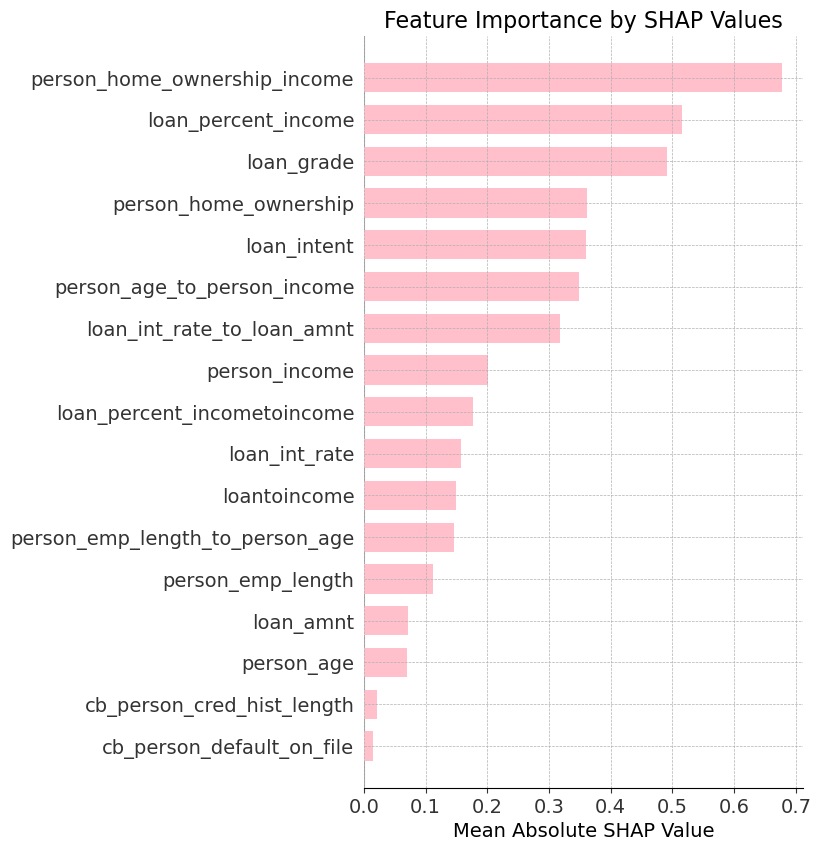

In [108]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type="bar", 
    class_names=np.unique(y_train),
    color='pink',
    show=False
)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.xlabel('Mean Absolute SHAP Value', fontsize=14) 
plt.title('Feature Importance by SHAP Values', fontsize=16) 
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5) 
plt.show()

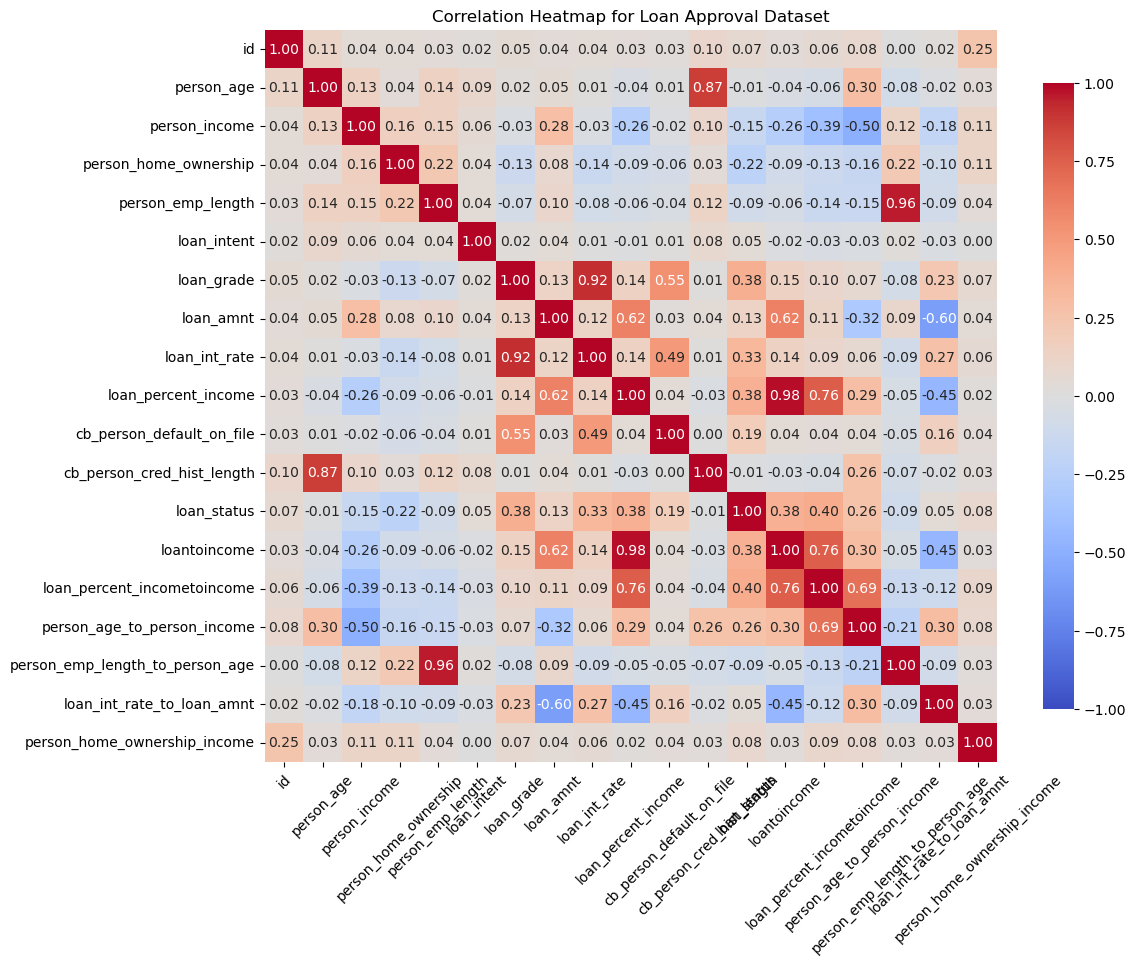

In [113]:
import seaborn as sns
correlation_matrix = train.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, 
            annot=True,
            fmt=".2f",          
            cmap='coolwarm',      
            square=True,           
            cbar_kws={"shrink": .8},  # Shrink color bar
            vmin=-1, vmax=1)      # Limits for color bar

plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()  # Adjusting layout

# Show the heatmap
plt.show()

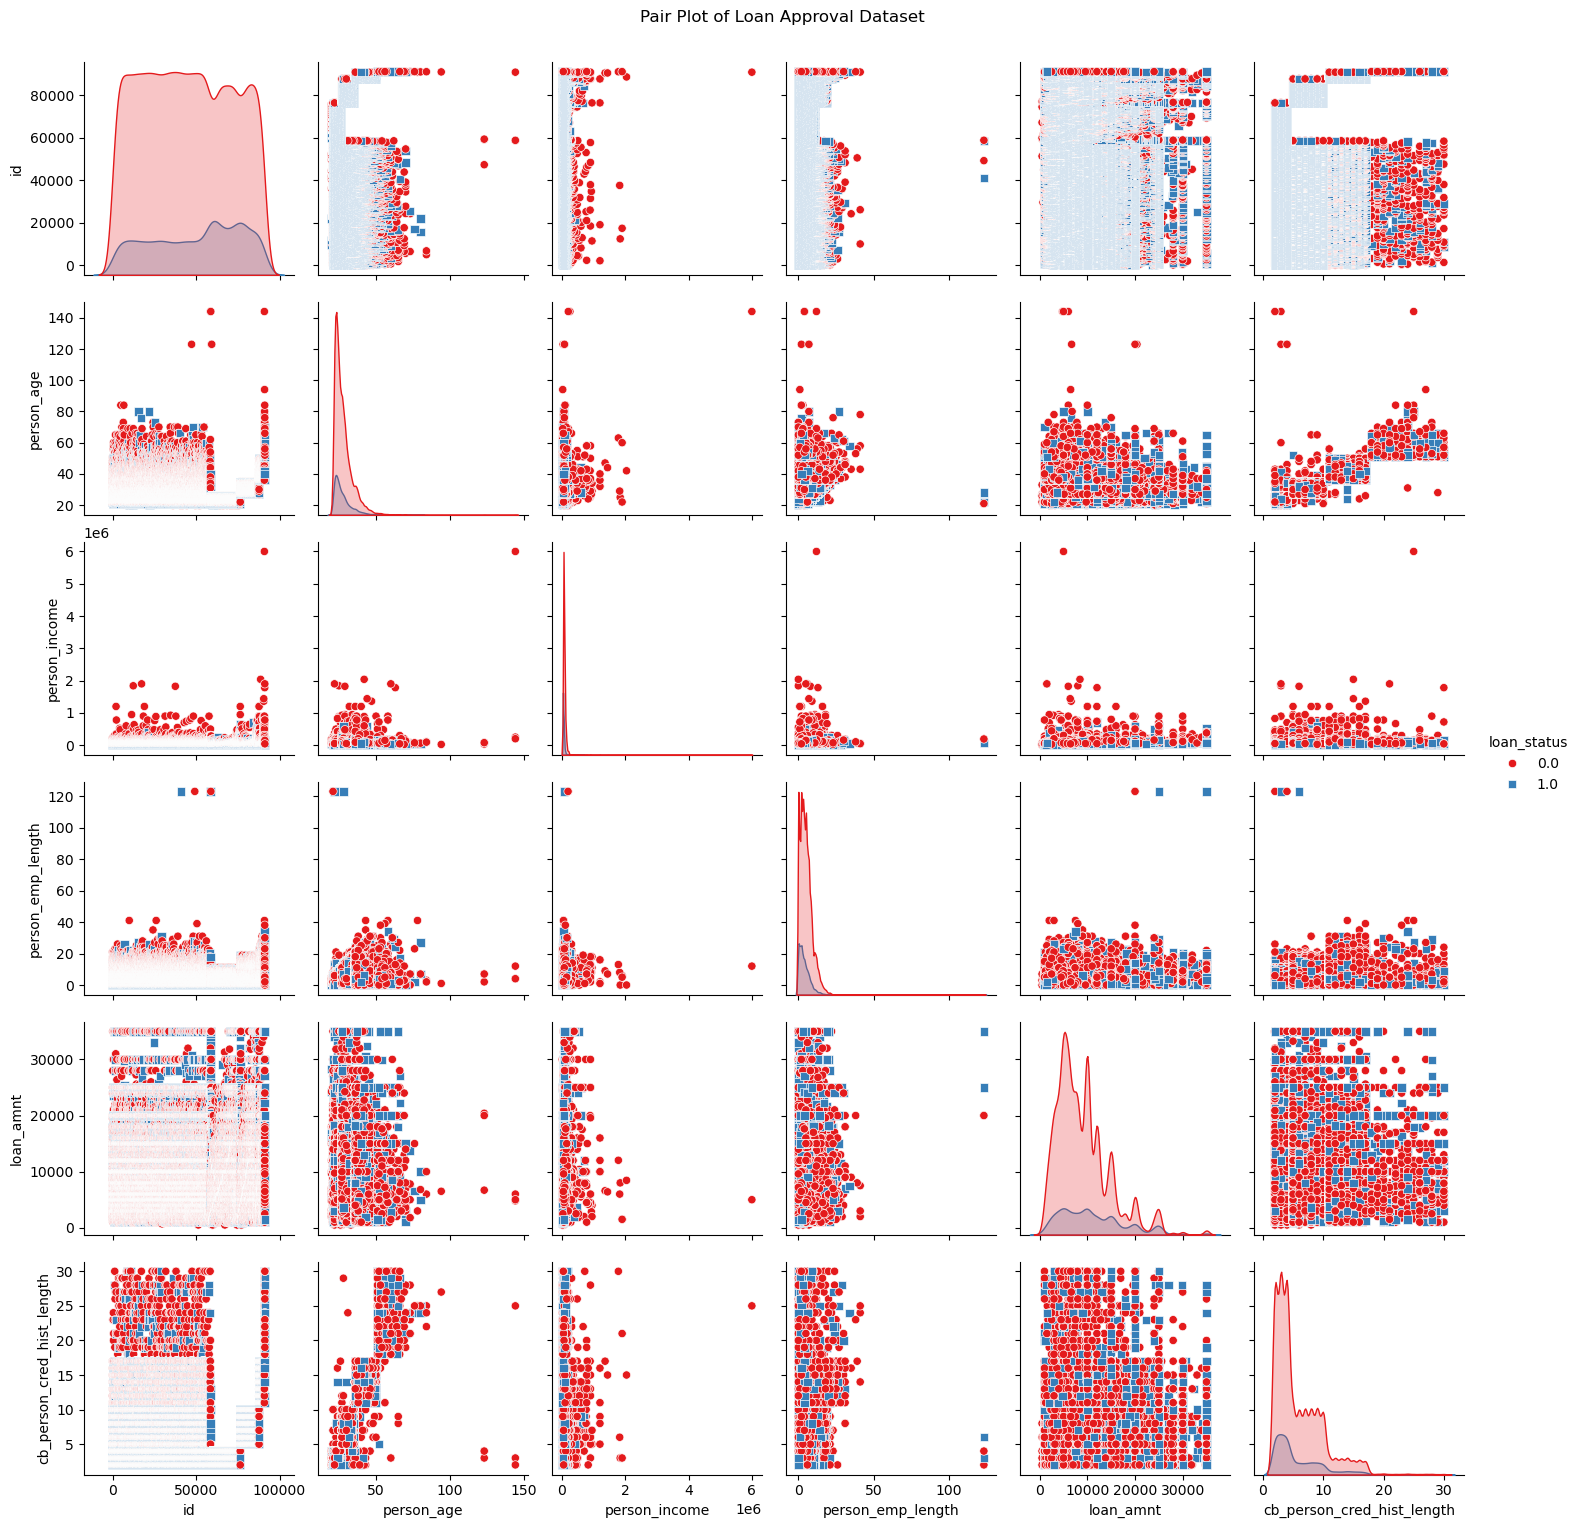

In [116]:
sns.pairplot(train, 
             hue='loan_status',  # Replace with your target variable
             diag_kind='kde',    # Kernel Density Estimation on the diagonal
             markers=["o", "s"], # Different markers for different classes
             palette='Set1',     # Color palette
             height=2.5)         # Size of the plots


plt.suptitle('Pair Plot of Loan Approval Dataset', y=1.02)  # Add a title
plt.show()

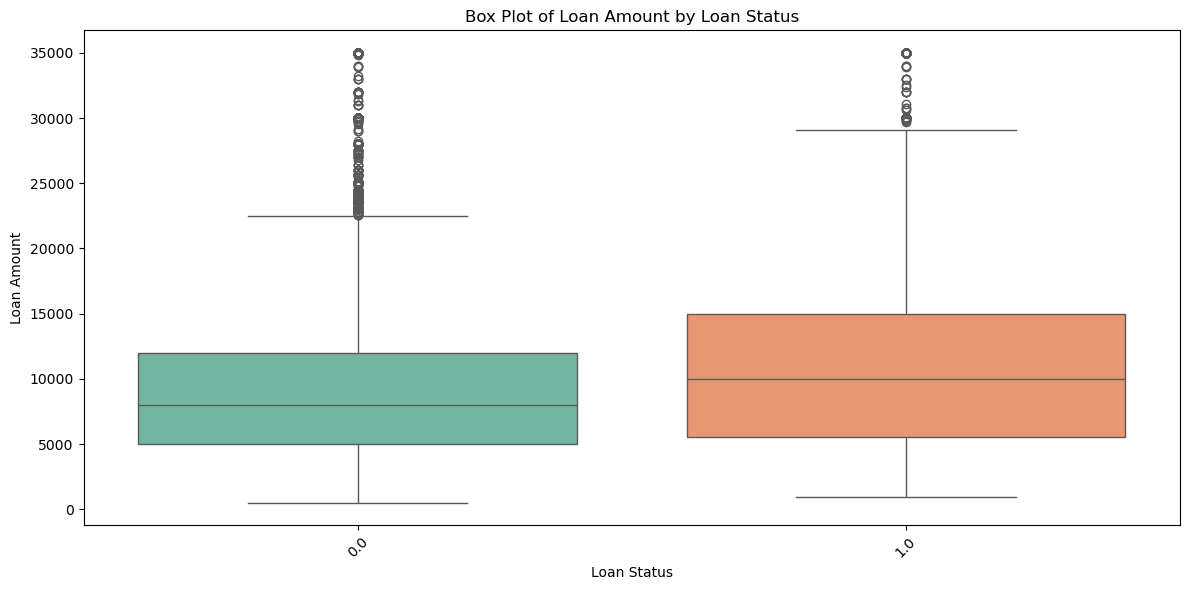

In [117]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='loan_amnt', data=train, palette='Set2')


plt.title('Box Plot of Loan Amount by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()


In [119]:
submission = test[['id']]
submission['loan_status'] = np.mean(preds, axis=0)

submission.to_csv('submission.csv', index=False)
submission

,id,loan_status
0,58645,0.998320
1,58646,0.014736
2,58647,0.207539
3,58648,0.005095
4,58649,0.063606
...,...,...
39093,97738,0.062569
39094,97739,0.003983
39095,97740,0.010640
39096,97741,0.141620


Text(0.5, 1.0, 'Loan Amount by Loan Status')

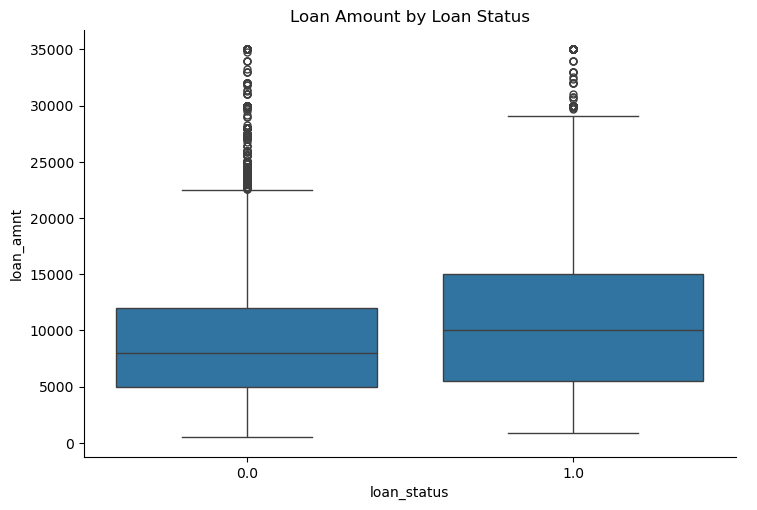

In [118]:
sns.catplot(x='loan_status', y='loan_amnt', data=train, kind='box', height=5, aspect=1.5)
plt.title('Loan Amount by Loan Status')